## Fraud Detection Analysis

In this analysis, the goal is to use the customer pattern information to idenetify the user fraud case.The project will start from loading data, feature extraction then building the model, fianlly make the recommendation based on result

## Contents

* Loading Data
* Feature Extraction
* Building Model
* Analysis and Recommendation 

In [278]:
#first import all the required package that will be used in following analysis
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import matplotlib
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.cross_validation import train_test_split 
from sklearn.pipeline import Pipeline 
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.ensemble.partial_dependence import partial_dependence
%matplotlib inline

### Loading Data

In [279]:
# fraud_data table includes user pattern information with
fraud_data=pd.read_csv('fraud_data.csv')
ip_address=pd.read_csv('IpAddress_to_Country.csv')
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [280]:
#ip_address table is used to identify user's country base don Ip_address
ip_address.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [281]:
#fraud_data table includes 151112 rows and 11 columns
print "Num of rows in fraud_data table: " + str(fraud_data.shape[0]) # row count
print "Num of columns in fraud_data table " + str(fraud_data.shape[1]) # col count

Num of rows in fraud_data table: 151112
Num of columns in fraud_data table 11


In [282]:
#ip_address table includes 138846 rows and 3 columns
print "Num of rows of ip_address table:" + str(ip_address.shape[0]) # row count
print "Num of columns of ip_address table: " + str(ip_address.shape[1]) # col count

Num of rows of ip_address table:138846
Num of columns of ip_address table: 3


### Feature Extraction

####  Adding contries columns based on ip_address
In this step, ip_address table is used to identify country based on ip_adddress lower and upper bound given information from fraud_data

In [211]:
#initialize a list storing countries information
country=len(fraud_data)*[0]

#for ind,row in fraud_data.iterrows:
for ind,row in fraud_data.iterrows():
    temp=ip_address[(ip_address['lower_bound_ip_address']<row['ip_address'])&(ip_address['upper_bound_ip_address']>row['ip_address'])]['country']
    
    if len(temp)==1:
        country[ind]=temp.values[0]
fraud_data['country']=country

In [285]:
#convert to csv file then import it
fraud_data.to_csv('full_data.csv')
data=pd.read_csv('full_data.csv')
data=data.drop('Unnamed: 0',axis=1)

In [286]:
#checking the data type
data.dtypes

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

In [287]:
# look at descriptive statistics of data
data.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


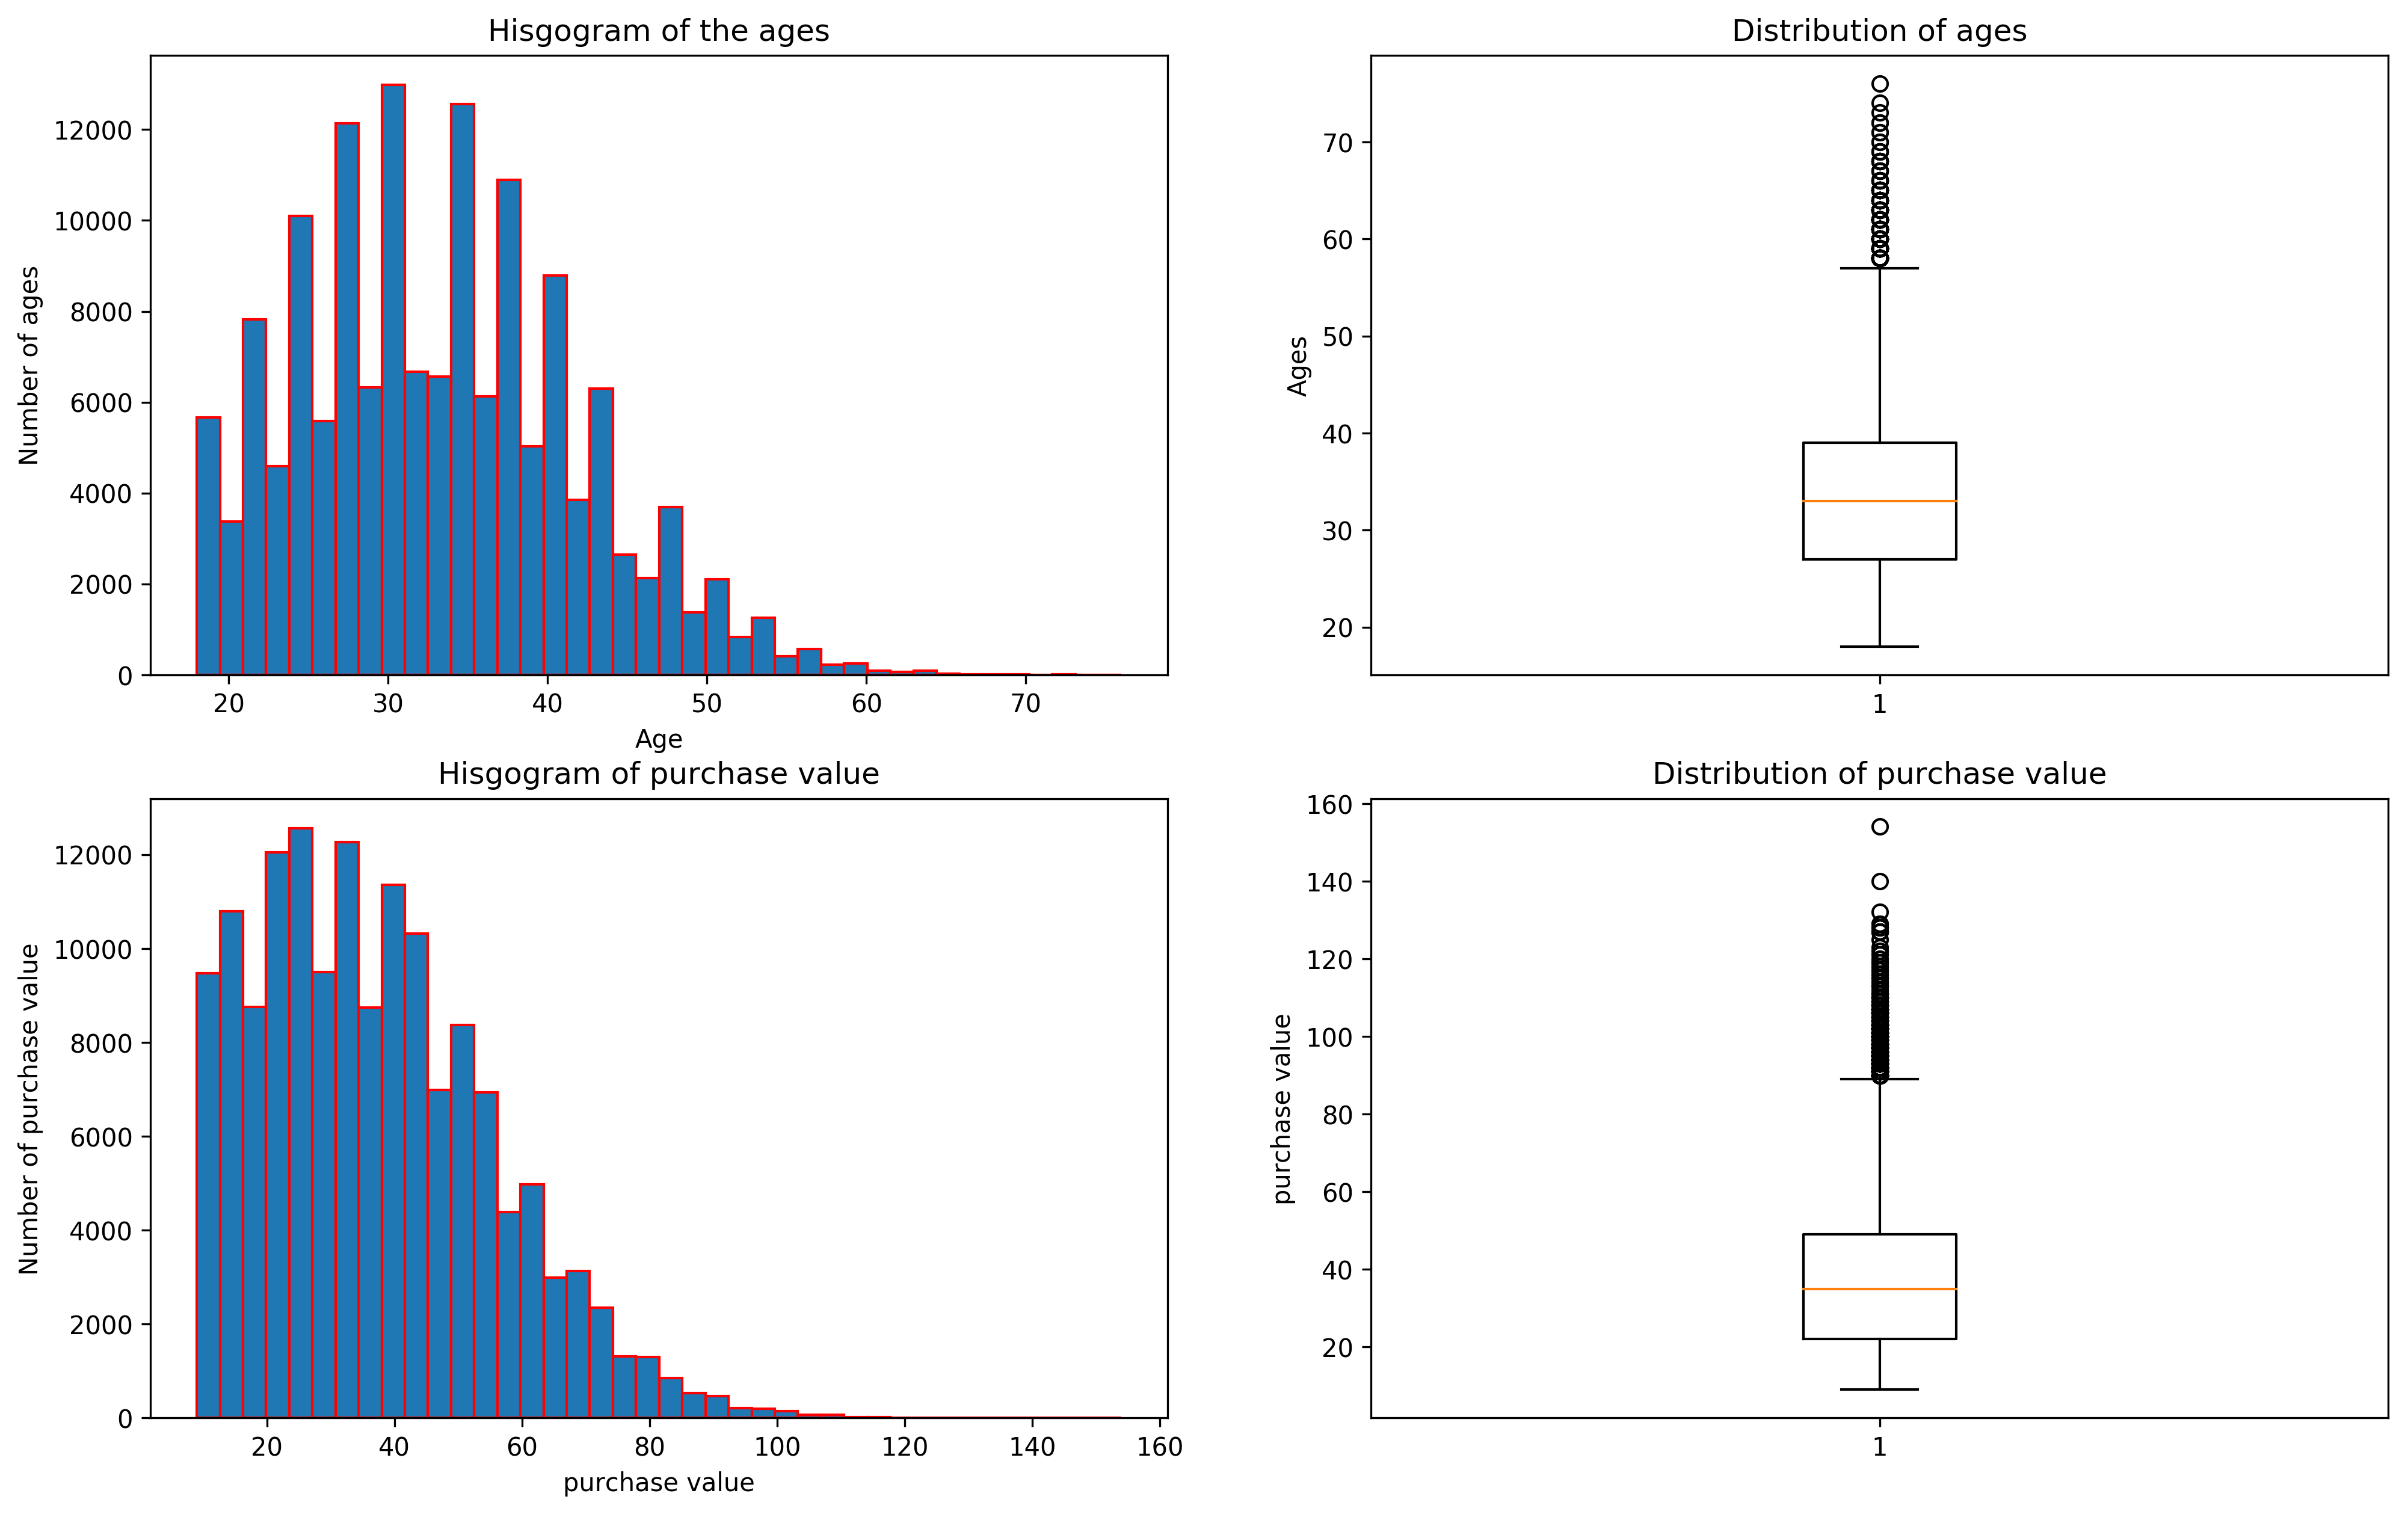

In [292]:
#check the distribution of age and purchase value
fig=plt.figure(dpi=300, figsize=(16, 10))

ax1=fig.add_subplot(2,2,1)
ax1.hist(data['age'],bins=40,edgecolor='red')
ax1.set_xlabel('Age')
ax1.set_ylabel('Number of ages')
ax1.set_title('Hisgogram of the ages')


ax2=fig.add_subplot(2,2,2)
ax2.boxplot(data['age'])
ax2.set_ylabel('Ages')
ax2.set_title('Distribution of ages')

ax3=fig.add_subplot(2,2,3)
ax3.hist(data['purchase_value'],bins=40,edgecolor='red')
ax3.set_xlabel('purchase value')
ax3.set_ylabel('Number of purchase value')
ax3.set_title('Hisgogram of purchase value')


ax4=fig.add_subplot(2,2,4)
ax4.boxplot(data['purchase_value'])
ax4.set_ylabel('purchase value')
ax4.set_title('Distribution of purchase value')

plt.show()

* From the above table, it can be seen that the averge purchase value is around 36 with the median around 35. This indicates that the purchase value is pretty evenly distributed.

* Minimum age as entered by the user is 18 with a max of 76 and an average 33 and median of 33. This indicates that the site consists of a lot of young users

* The percentage of fraudulent activity is around 9%. This is slightly on the high end and needs to be looked into.

#### Feature engineering

* Create new feature represents difference between signup time and purchase time

In [216]:
#First,converting signup time and purchase time to datetime objects
data['signup_time']=pd.to_datetime(data['signup_time'])
data['purchase_time']=pd.to_datetime(data['purchase_time'])

#Difference between signup time and purchase time
data['diff_time']=(data['purchase_time']-data['signup_time'])/np.timedelta64(1,'s')

* Create feature that records use frequency per device, for different user id's using the same device could be an indication of a fake transaction

In [220]:
#Different user id's using the same device
device_user_count = len(data) * [0]
device_count = data.groupby('device_id')['user_id'].count()
device_user_count = device_count[data['device_id']]
device_user_count = device_user_count.reset_index().drop('device_id', axis = 1)
device_user_count.columns = ['device_user_count']
#adding new features to data table
data = pd.concat([data, device_user_count], axis = 1)

* The same case also applies for ip_address,create feature records the use frequency per ip_address

In [223]:
#number of users using a given ip address
ip_count=data.groupby('ip_address')['user_id'].count()
ip_count=ip_count[data['ip_address']].reset_index().drop('ip_address',axis=1)
ip_count.columns=['ip_count']
#adding new feature to data table
data=pd.concat([data,ip_count],axis=1)

* Since there are many distince values for country, select top 50 countries in terms of user_id number to avoid over learning problem, 

In [224]:
#Keeping only the top 50 countries and replacing everything else with 'Other'

temp = pd.DataFrame(data.groupby('country')['user_id'].count()).sort_values('user_id',ascending=False)
temp=temp.iloc[:50,:].loc[data['country']].reset_index()
temp.loc[temp.isnull().any(axis=1),'country']='other'
temp.loc[temp['country']=='0','country']='other'
temp=temp.drop('user_id',axis=1)
temp.columns=['country_revised']
data=pd.concat([data,temp],axis=1)
data=data.drop('country',axis=1)
data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,diff_time,device_user_count,ip_count,country_revised
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,4506682.0,1,1,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,17944.0,1,1,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,1.0,12,12,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,492085.0,1,1,other
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,4361461.0,1,1,United States


### Building Model

* In this case, we use the random forest to make predictions,the reason is that as an ensemble model, by introducing bagging idea random forest can reduce the overfitting problem(bagging on observations and features), also random forest is dealing well with imbalanced classification problem.Finanly, the feature importance can help understand which feature contribute more or less to classification results

In [225]:
#response variable
y=data['class']
#predictors,remove some irrelavent features that don't convery significant meanings
data=data.drop(['user_id','signup_time','purchase_time','class'],axis=1)
X=data

In [226]:
#check there are no missing values
X.isnull().sum()

purchase_value       0
device_id            0
source               0
browser              0
sex                  0
age                  0
ip_address           0
diff_time            0
device_user_count    0
ip_count             0
country_revised      0
dtype: int64

In [227]:
#Label Encoding String variables
lb=LabelEncoder()
X['device_id'] = lb.fit_transform(X['device_id'])
X['source'] = lb.fit_transform(X['source'])
X['browser'] = lb.fit_transform(X['browser'])
X['sex'] = lb.fit_transform(X['sex'])
X['country_revised'] = lb.fit_transform(X['country_revised'])

In [228]:
#spliting data into train and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [230]:
#Creating a pipeline and randomforest model
pipeline=Pipeline(steps = [('clf', RandomForestClassifier(criterion = 'entropy'))])
clf_forest = RandomForestClassifier(n_estimators= 20, criterion = 'entropy', max_depth= 50, min_samples_leaf= 3,
                                    min_samples_split= 3, oob_score= True)

In [231]:
clf_forest.fit(X_train,y_train)

C:\Users\yange\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\yange\AppData\Local\Continuum\Anaconda2\lib\site-packages\sklearn\ensemble\forest.py:444: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=50, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=3,
            min_samples_split=3, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=True, random_state=None,
            verbose=0, warm_start=False)

In [234]:
#Output the confusion matrix
print classification_report(y_test,preds)

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     34223
          1       0.99      0.54      0.70      3555

avg / total       0.96      0.96      0.95     37778



* From the above, it is very clear that we are able to predict fraud with a precision of 98% and a recall of 54%. This implies of all the times we predicted fraud, we were right 98% of the time. Similarly, of all the fraud that has taken place, we were able to correctly identify only 54% of it. It is clear that we need to improve our recall rate even if it reduces the precision. This is act of balancing false positives and false negatives.A false positive would imply more checks on a potentially non fraudulent customer. A false negative would imply an act of fraud going undetected.Thus we need to decrease false negatives, even if it is at the cost of false positives. This would automatically improve our recall/sensitivity score.

In [236]:
# Print the feature ranking
importances = clf_forest.feature_importances_

print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), X), reverse=True):
    print v + ": " + str(k)

Feature importance ranking by Random Forest Model:
diff_time: 0.3355
device_user_count: 0.1986
ip_count: 0.1324
ip_address: 0.0797
device_id: 0.0777
purchase_value: 0.0611
age: 0.0504
country_revised: 0.0296
browser: 0.0158
source: 0.0112
sex: 0.0081


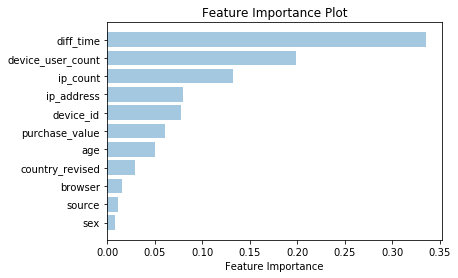

In [237]:
#define function to plot feature importance
def plot_feature_importance(feature_name,feature_importance):
    ftr_imp_df=pd.DataFrame(sorted(zip(feature_name,feature_importance),key=lambda x:x[1],reverse=False))
                            
    y_pos=np.arange(ftr_imp_df.shape[0])
                            
    plt.barh(y_pos,ftr_imp_df[1],align='center',alpha=0.4)
    plt.yticks(y_pos,ftr_imp_df[0])
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Plot')
                            
    plt.show()
plot_feature_importance(X,importances)

* Looking from plot, the diff_time,device_user_count and ip_count rank the three most important features,which are power identifying the fraud case

In [238]:
#Output out of bag score
clf_forest.oob_score_

0.95538849771471934

### Analysis and Recommendation

* In this step, we set the optimal threshold for classification to improve the sensitivity(recall) at cost of specificity

In [246]:
#Output prediction probabilities
prob_score=clf_forest.predict_proba(X_test)
#extracting positive case(frand) prediction 
prob_score=DataFrame(prob_score).iloc[:,1]

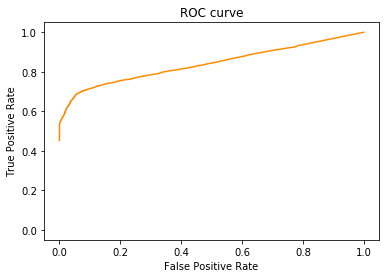

In [248]:
fpr,tpr,thresholds = roc_curve(y_test,prob_score)
#Plotting the ROC curve
plt.plot(fpr,tpr, color = 'darkorange')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [256]:
#Find the optimal cut off by maximize absolute value of difference between sensitivity and specificity.
i = np.arange(len(fpr))
roc = DataFrame({'fpr' : Series(fpr, index=i),'tpr(recall)' : Series(tpr, index = i), '1-fpr(specificity)' : Series(1-fpr, index = i), 
                    'tf' : Series(tpr - (1-fpr), index = i), 'thresholds' : Series(thresholds, index = i)})
roc.iloc[(roc['tf']-0).abs().argsort()[[0]]]

,1-fpr(specificity),fpr,tf,thresholds,tpr(recall)
2264,0.764427,0.235573,0.00013,0.05754,0.764557


[]

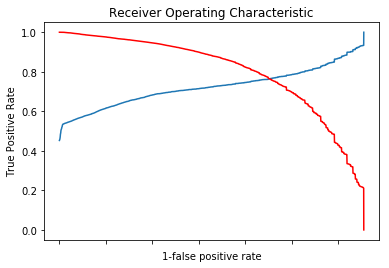

In [263]:
fig, ax = plt.subplots(1)
plt.plot(roc['tpr(recall)'])
plt.plot(roc['1-fpr(specificity)'], color = 'red')
plt.xlabel('1-false positive rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
ax.set_xticklabels([])

* The optimal cut off point from the above graph can be deduced to be 0.06. Predictions above this value can be labelled as 1(fraud).Predictions below the value can be labelled as 0(non fraud).The TPR at the threshold is 76%.the FPR at threshold is 23%

In [265]:
#After setting cut off value, we rebuild the model and output the confusion matrix
prob = clf_forest.predict_proba(X_test)[:,1]
prob[prob > 0.06] = 1
prob[prob <= 0.06] = 0
print classification_report(y_test, prob)

             precision    recall  f1-score   support

          0       0.97      0.78      0.86     34223
          1       0.26      0.76      0.39      3555

avg / total       0.90      0.78      0.82     37778



#### Recommendations


*  case of fraudulent activities the cost of a False Negative is much more expensive than the cost of a False Positive.Hence, it is alright to predict more customers as falsely positive of fraud rather than let a fraudulent customer get away with the act

* As it can be seen from the above table, precision has come down to 26% whereas recall/sensitivity has gone up to 77% from a mere 56% in the previous model.With more customers predicted as 1, it will decrease precision but increase sensitivity

* The wrongly suspected customers can be made to go through an additional security check either in the form of answering a personal question or request for SSN or temporarily freezing the account etc.At the same time with this new model, customers wouldn't be able to get away with fraud